# Long Short-Term Memory (LSTM)


While the RNN model is able to handle the sequence data, it struggles with the long-term dependencies. Long Short-Term Memory (LSTM) model {footcite}`hochreiter1997long` is designed to overcome this limitation by introducing a "controlled" memory cell that can maintain information over long periods.

## LSTM Architecture

```{figure} ../figs/lstm.jpg
---
name: lstm
---

LSTM architecture showing the cell state (horizontal line at top) and the three gates: forget gate, input gate, and output gate. The cell state acts as a conveyor belt carrying information forward, while gates control information flow.
```

The input and output of LSTM is fundamentally the same as the simple RNN we have seen before. The only difference is that LSTM has two kinds of hidden states: the hidden state $h_t$ and the cell state (or memory cell) $c_t$.
The hidden state $h_t$ is the output of the LSTM, and it is used to predict the next state. The cell state $c_t$ is the internal state of the LSTM, and it is used to maintain the memory of the LSTM.
Think of this cell as a conveyor belt that runs straight through the network, allowing information to flow forward largely unchanged. This cell state forms the backbone of the LSTM's memory system.

### Deep Dive into LSTM

Internally, LSTM controls the flow of information through the cell state by using three gates: the forget gate, the input gate, and the output gate. Let us break down each gate and see how they work.



#### Forget Gate

```{figure} ../figs/lstm-forget-gate.jpg
---
width: 400px
name: lstm-01
align: center
---

Forget gate. $\sigma(x_t, h_t)$ decides how much of the previous cell state $c_{t-1}$ to keep. For example, if $\sigma(x_t, h_t) = 0$, the forget gate will completely forget the previous cell state. If $\sigma(x_t, h_t) = 1$, the forget gate will keep the previous cell state. $\sigma$ is the sigmoid function which is bounded between 0 and 1.
```

The *forget gate* examines the current input and the previous hidden state to decide what information to remove from the cell state. Like a selective eraser, it outputs values between 0 and 1 for each number in the cell state, where 0 means "completely forget this" and 1 means "keep this entirely."


#### Input Gate

```{figure} ../figs/lstm-input-gate.jpg
---
width: 400px
name: lstm-02
align: center
---

Input gate. $\sigma(x_t, h_t)$ decides how much of the new information (that passes through the tanh function) to add to the cell state. For example, if $\sigma(x_t, h_t) = 0$, the input gate will completely ignore the new candidate information. If $\sigma(x_t, h_t) = 1$, the input gate will add the new candidate information to the cell state.
```

The input gate works together with a candidate memory generator to decide what new information to store. The input gate determines how much of the new candidate values should be added to the cell state, while the candidate memory proposes new values that could be added. This mechanism allows the network to selectively update its memory with new information.


#### Output Gate

```{figure} ../figs/lstm-output-gate.jpg
---
width: 400px
name: lstm-03
align: center
---
Output gate. $\sigma(x_t, h_t)$ decides how much of the cell state to reveal as output. For example, if $\sigma(x_t, h_t) = 0$, the output gate will completely hide the cell state. If $\sigma(x_t, h_t) = 1$, the output gate will reveal the cell state.
```

The output gate controls what parts of the cell state should be revealed as output. It applies a filtered version of the cell state to produce the hidden state, which serves as both the output for the current timestep and part of the input for the next timestep.

```{note}
The key innovation of LSTMs is not just having memory, but having controlled memory. The network learns what to remember and what to forget, rather than trying to remember everything.
```

### Mathematical Framework

The LSTM's operation can be described through a series of equations that work together to process sequential data. The cell state $C_t$ evolves according to:

$$ C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t $$

where $f_t$ is the forget gate, $i_t$ is the input gate, and $\tilde{C}_t$ is the candidate memory. The $\odot$ symbol represents element-wise multiplication, allowing the gates to control information flow by scaling values between 0 and 1.

The gates themselves are neural networks that take the current input $x_t$ and previous hidden state $h_{t-1}$ as inputs:

$$ f_t = \sigma(W_f[h_{t-1}, x_t] + b_f) $$
$$ i_t = \sigma(W_i[h_{t-1}, x_t] + b_i) $$
$$ o_t = \sigma(W_o[h_{t-1}, x_t] + b_o) $$

The candidate memory is generated similarly:

$$ \tilde{C}_t = \tanh(W_c[h_{t-1}, x_t] + b_c) $$

Finally, the hidden state is produced by:

$$ h_t = o_t \odot \tanh(C_t) $$


```{admonition} Memory Challenge Game 👾
:class: tip

Let us learn how LSTM works by playing [a memory challenge game 🎮](memory-challenge.md). Given a sequence of numbers and possible questions, your job is to manage a limited memory to compress the sequence into three numbers 🧮.
```


## Hands on

We will train an LSTM model to identify a wrapped character in a sequence. The task is to predict which character is enclosed in `<>` tags within a sequence of randomly ordered uppercase letters. For example,

- Input: `ABCDEFGHIJKLMNOPQRST<U>VWXYZ`
- Output: `U`

This requires a selective memory that can remember the wrapped character and forget the rest of the characters, which is exactly what LSTM is designed for.

Let us first import the necessary libraries.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import random
import string

Then, we define the data generation function.

In [2]:
def generate_wrapped_char_data(n_samples=1000, seq_length=26):
    """
    Generate training data where one random character in a sequence is wrapped with <>.

    Args:
        n_samples (int): Number of sequences to generate
        seq_length (int): Length of each sequence (default 26 for A-Z)

    Returns:
        list: List of input sequences
        list: List of target characters (the wrapped characters)
    """
    sequences = []
    targets = []

    for _ in range(n_samples):
        # Generate a random permutation of A-Z
        chars = list(string.ascii_uppercase)
        random.shuffle(chars)

        # Choose a random position for the wrapped character
        wrap_pos = random.randint(0, seq_length - 1)
        target_char = chars[wrap_pos]

        # Create the sequence with wrapped character
        chars.insert(wrap_pos, "<")
        chars.insert(wrap_pos + 2, ">")
        sequence = "".join(chars)

        sequences.append(sequence)
        targets.append(target_char)

    vocab = list(string.ascii_uppercase) + ["<", ">"]

    return sequences, targets, vocab

sequences, targets, vocab = generate_wrapped_char_data(n_samples = 3)

for seq, target in zip(sequences, targets):
    print(f"Sequence: {seq}, Target: {target}")

Sequence: NLP<W>QGCFOIUYEJRZAMTVSKXBDH, Target: W
Sequence: IWNYKSDGRVXMAZ<F>CQULHBJOEPT, Target: F
Sequence: YAPSTXJ<F>IEOLKDVZQRHNCGWUMB, Target: F


This function generates our training data by creating n_samples sequences, where each sequence is a random permutation of A-Z letters. In each sequence, one random character is wrapped with <> tags. The function returns both the generated sequences and their corresponding target characters (the wrapped ones) as separate lists.

The next step is to convert the sequences into tokenized representations that can be fed into the LSTM model.

In [3]:

def tokenize(sequences, vocab):
    retval = []
    for seq in sequences:
        r = []
        for char in seq:
            r.append(vocab.index(char))
        retval.append(r)
    return torch.tensor(retval)

X = tokenize(['ABCDEFGHIJKLMNOPQRST<U>VWXYZ', 'ABCDEFGHIJKLMNOPQRSTU<V>WXYZ'], vocab)
print("X:", X)
print("Shape of X:", X.shape)

X: tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 26, 20, 27, 21, 22, 23, 24, 25],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 26, 21, 27, 22, 23, 24, 25]])
Shape of X: torch.Size([2, 28])


The output tensor `X` is of shape `(2, 28)`, where `2` is the number of samples, and `28` is the sequence length.

Now, let's prepare the data and train the LSTM model. As before, we will use PyTorch's `TensorDataset` and `DataLoader` to handle the data.

In [4]:
from torch.utils.data import Dataset

# Generate data
sequences, targets, vocab = generate_wrapped_char_data(n_samples=1000)

# Tokenize data
sequences = tokenize(sequences, vocab)
targets = tokenize(targets, vocab)

# Create dataset
dataset = TensorDataset(sequences, targets)

# Split dataset into train and validation
train_frac = 0.8
batch_size = 128
train_size = int(train_frac * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

This creates an efficient data loading pipeline that combines our features and targets into a unified dataset structure. The data loader then handles batching the data, with a batch size of 128 samples which is a common choice that balances between training speed and memory usage. The loader also shuffles the data between epochs, which helps prevent the model from learning any unintended patterns based on the order of samples and improves generalization.

Now, let's define the model parameters and initialize the LSTM and output layer.

In [5]:
import pytorch_lightning as pyl

class CharDecoder(pyl.LightningModule):
    def __init__(self, vocab_size, output_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=vocab_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_size, output_size)
        self.embedding = nn.Embedding(vocab_size, vocab_size)

        # One-hot encoding
        self.embedding.weight.data = torch.eye(vocab_size)
        self.embedding.weight.requires_grad = False

        # Validation loss
        self.val_losses = []

    def forward(self, x):

        # x is a tensor of shape (batch_size, seq_len)
        batch_size, seq_len = x.shape

        # To token index to one-hot encoding
        x = self.embedding(x)

        # To sentnece to sequence of chars
        hidden = self.init_hidden(batch_size)
        x, _ = self.lstm(x, hidden)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y.reshape(-1))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        with torch.no_grad():
            x, y = batch
            y_hat = self(x)
            loss = torch.nn.functional.cross_entropy(y_hat, y.reshape(-1))
            self.log("val_loss", loss)
            self.val_losses.append(loss.cpu().item())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)

    def init_hidden(self, batch_size):
        return (
            torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size, device=self.device),
            torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size, device=self.device),
        )

In [6]:
model = CharDecoder(
    vocab_size=28,
    output_size=28,
    hidden_size=32,
    num_layers=1,
)

- `num_layers=1`: The model uses a single-layer LSTM architecture for sequence processing.
- `vocab_size=28`: The input dimension matches the vocabulary size to handle the one-hot encoded characters.
- `hidden_size=32`: The LSTM contains 32 hidden units per layer to learn complex sequential patterns in the data.
- `output_size=28`: The output from the LSTM feeds into a final linear layer that performs classification over the vocabulary space.


```{tip}
The LSTM model can be stacked with multiple layers to learn more complex patterns {footcite:p}`irsoy2014opinion`. For example, `num_layers=2` will stack two LSTM layers on top of each other. The first layer will take the input and produce a hidden state, which will be used as the input for the second layer. The second layer will then produce the final hidden state and output. By stacking multiple layers, the model can learn more complex patterns in the data.

```{figure} https://i.sstatic.net/QxzoG.png
---
width: 400px
name: lstm-04
align: center
---

LSTM with multiple layers.
```

```{tip}
`torch.nn.Embedding` is a convenient way to convert token indices to vectors. By default, it uses random initialization, but we can use one-hot encoding by setting `self.embedding.weight.data = torch.eye(vocab_size)`, and fix the weights by setting `self.embedding.weight.requires_grad = False`.
```

```{tip}
In PyTorch lightning, `configure_optimizers` is a method that returns the optimizer and the learning rate scheduler.
We use ADAM {footcite}`kingma2014adam` as the optimizer. It is a popular optimizer for deep learning. It is a variant of stochastic gradient descent that can adaptively adjust the learning rate for each parameter using the first and second moments of the gradients.
```

Now, let's train the model.

In [7]:
trainer = pyl.Trainer(
    max_epochs=200,
    enable_progress_bar=False,
    enable_model_summary=False,
)
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


`Trainer.fit` stopped: `max_epochs=200` reached.


Let's plot the training loss.

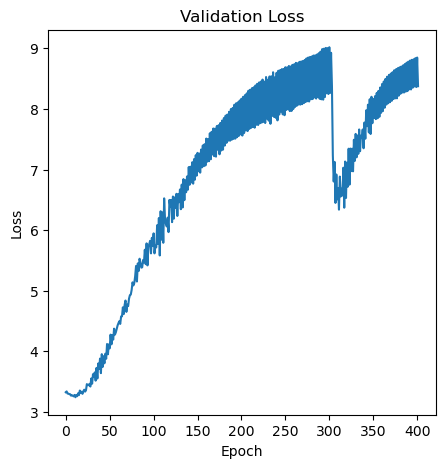

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (5,5))
ax.plot(model.val_losses)
ax.set_title("Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
plt.show()

The loss did not decrease nicely. This is a sign of the struggle of the LSTM model to learn the data. If you see this, you might need to decrease the learning rate, increase the number of epochs untile the loss becomes stable, or re-design the model architecture.

Nevertheless, let's test the model.

In [9]:
eval_seq, eval_target, vocab = generate_wrapped_char_data(n_samples=5)
X_eval = tokenize(eval_seq, vocab)
y_eval = tokenize(eval_target, vocab)

model.eval()
with torch.no_grad():
    y_hat = model(X_eval)
    predicted_idx = torch.argmax(y_hat, dim=1)
    predicted_char = [vocab[idx] for idx in predicted_idx]

    for i in range(len(eval_seq)):
        print(f"Sequence: {eval_seq[i]}, Target: {eval_target[i]}, Predicted: {predicted_char[i]}")
    accuracy = (predicted_idx == y_eval).sum() / len(y_eval)
    print(f"Accuracy: {accuracy}")


Sequence: TBMNYZEKIRFSJP<O>XLHADUVCQWG, Target: O, Predicted: B
Sequence: TLEHYQAUCGOJ<X>WFNMPKBISZVDR, Target: X, Predicted: L
Sequence: MPXVHBEUYRWCKSNIOG<A>QZFTDJL, Target: A, Predicted: E
Sequence: SOFMH<I>GNYKXDREAUTLWVJBZPCQ, Target: I, Predicted: R
Sequence: UANF<H>QBYKZMDRLTOVGJXPEIWCS, Target: H, Predicted: E
Accuracy: 0.0


We see that the validation loss increased as the training progressed. This implies overfitting, i.e. the model is too expressive and memorizes the training data but lacks the understanding of underlying patterns and thereby generalizes poorly to unseen data. This is a common problem in deep learning.

```{admonition} Regularization
:class: tip

Regularization is a technique to prevent a model from overfitting. A traditional way to regularize a model is to add a penalty term to the loss function, e.g., $L = L_{\text{data}} + \lambda L_{\text{reg}}$, where $L_{\text{data}}$ is the data loss and $L_{\text{reg}}$ is the regularization loss.
Another popular regularization technique is dropout {footcite}`srivastava2014dropout`, which randomly drops out some neurons during training to prevent the model from relying too heavily on specific features.


```{figure} https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/1IrdJ5PghD9YoOyVAQ73MJw.gif
:alt: Dropout
:width: 50%
:align: center

Dropout.
```

## 🔥 Exercise 🔥

Let's fix the model by doing the following:

1. Try increasing the number of hidden units in the LSTM model.
2. Bring back to the original number of hidden units, and try increasing the number of layers in the LSTM model.
3. Add dropout to the model by using `torch.nn.Dropout` on the output of the LSTM layer.
4. Try increasing the learning rate.
5. Play with other hyperparameters, e.g., the number of epochs, batch size, etc.
5. Change the model to `nn.RNN` instead of `nn.LSTM`. You should replace `(h_n, c_n)` with `hidden` in the training and evaluation since `nn.RNN` does not have a cell state.

You should be able to see the model to correctly predict the wrapped character.

```{footbibliography}
:style: unsrt
```